In [1]:
import geemap
import ee
from Monarch import user_gee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import rcParams
import os

In [2]:
os.chdir(r"E:/Paper/Data/")

In [3]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [4]:
roi = geemap.shp_to_ee('roi_shp/jiujiang.shp').geometry()
Map.center_object(roi, 8)
Map.addLayer(roi, {}, 'roi')

In [5]:
points = geemap.shp_to_ee('landuse/points.shp')
rice_points = points.filter(ee.Filter.eq('RASTERVALU', 2))

In [ ]:
visParams = {'max': 3000, 'min': 0, 'bands': ['B4', 'B3', 'B2']}

In [ ]:
for year in range(2019, 2020):
    s2_year = []
    for i in range(3, 11):
        s2 = ee.ImageCollection("COPERNICUS/S2")\
                .filterBounds(roi)\
                .sort('CLOUD_COVERAGE_ASSESSMENT', False)\
                .filterDate(str(year), str(year+1))\
                .filter(ee.Filter.calendarRange(i, i, 'month'))\
                .map(user_gee.rm_cloud_s2_sr)\
                .mosaic()
        Map.addLayer(s2, visParams, f"s2_{i}")
        s2_year.append(s2)
    s2_year = ee.ImageCollection(s2_year)

In [6]:
config = {
    "font.family": 'serif',
    "font.size": 14,
    "mathtext.fontset": 'stix',
    "font.serif": 'Simsun',
}
rcParams.update(config)

ProxyError: ('Cannot connect to proxy.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))

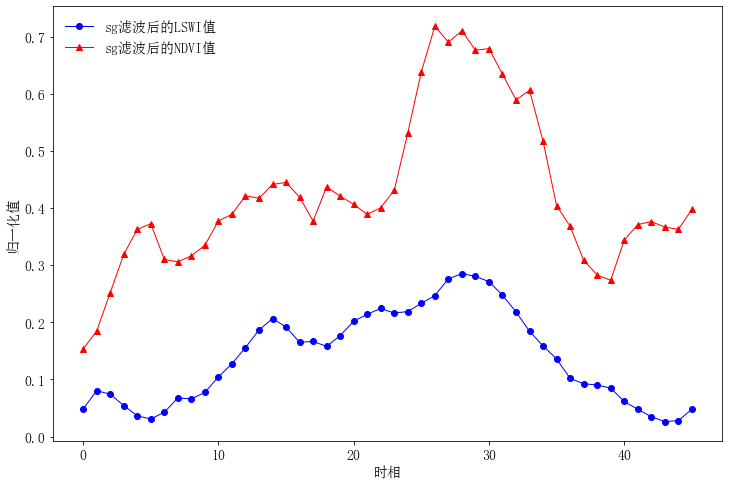

In [7]:
for year in range(2016, 2020):
    modis = ee.ImageCollection("MODIS/006/MOD09A1").filterDate(str(year), str(year+1))\
                .map(lambda img: img.clip(roi))
    ndvi = modis.map(lambda img: img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi']))
    lswi = modis.map(lambda img: img.normalizedDifference(['sur_refl_b02', 'sur_refl_b06']).rename(['lswi']))
    
    ndvi_img = ndvi.toBands().rename([f'ndvi_{i}' for i in range(46)])
    ndvi_training = ndvi_img.sampleRegions(**{
      'collection': rice_points,
      'scale': 500
    })
    lswi_img = lswi.toBands().rename([f'lswi_{i}' for i in range(46)])
    lswi_training = lswi_img.sampleRegions(**{
      'collection': rice_points,
      'scale': 500
    })
    
    ndvi_data = [ndvi_training.aggregate_array(f'ndvi_{i}').getInfo() for i in range(46)]
    lswi_data = [lswi_training.aggregate_array(f'lswi_{i}').getInfo() for i in range(46)]
    ndvi_data = np.array(ndvi_data)
    lswi_data = np.array(lswi_data)
    ndvi_sg_data = savgol_filter(ndvi_data, 11, 4, axis=0)
    lswi_sg_data = savgol_filter(lswi_data, 11, 4, axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlabel('时相')
    ax.set_ylabel('归一化值')
    ax.plot([i for i in range(46)], lswi_sg_data.mean(1), '-o', color='blue', lw=1, label='sg滤波后的LSWI值')
    ax.plot([i for i in range(46)], ndvi_sg_data.mean(1), '-^', color='r', lw=1, label='sg滤波后的NDVI值')
    ax.legend(loc=2, frameon=False, handlelength=2)
    fig.savefig(f'N_L_img/{year}_4_N_L.png', dpi=600, bbox_inches='tight')

In [ ]:
config = {
    "font.family": 'serif',
    "font.size": 14,
    "mathtext.fontset": 'stix',
    "font.serif": 'Simsun',
}
rcParams.update(config)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('时相')
ax.set_ylabel('NDVI值')
ax.plot([i for i in range(46)], ndvi_data.mean(1), '-o', color='blue', lw=1, label='原始的NDVI值')
ax.plot([i for i in range(46)], ndvi_sg_data.mean(1), '-^', color='r', lw=1, label='sg滤波后的NDVI值')
ax.legend(loc=2, frameon=False, handlelength=2)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('时相')
ax.set_ylabel('LSWI值')
ax.plot([i for i in range(46)], lswi_data.mean(1), '-o', color='blue', lw=1, label='原始的LSWI值')
ax.plot([i for i in range(46)], lswi_sg_data.mean(1), '-^', color='r', lw=1, label='sg滤波后的LSWI值')
ax.legend(loc=0, frameon=False, handlelength=2, )